# connectLib Pipeline

## Algorithm

**Description:** The connectLib Pipeline filters out the background noise of an n-dimensional image and then segments the resulting image into groups of data type Cluster presented in list-form. 

**Inputs:** 
    1. the image to be segmented

**Outputs:**
    1. the list of clusters (data type: Cluster)
    
**Function**

In [ ]:
###Step 1: Threshold the image using Otsu Binarization 
    probVox = np.nan_to_num(argVox)
    bianVox = np.zeros_like(probVox)
    for zIndex, curSlice in enumerate(probVox):
        #if the array contains all the same values
        if np.max(curSlice) == np.min(curSlice):
            #otsu thresh will fail here, leave bianVox as all 0's
            continue
        thresh = threshold_otsu(curSlice)
        bianVox[zIndex] = curSlice > thresh
    return bianVox

###Step 2: segments the thresholded image into a list of clusters
    labelMap = label(voxel)
    clusterList = []
    #plus 1 since max label should be included
    for uniqueLabel in range(0, np.max(labelMap)+1):
        memberList = [list(elem) for elem in zip(*np.where(labelMap == uniqueLabel))]
        if not len(memberList) == 0:
            clusterList.append(Cluster(memberList))
    return clusterList

## Write Code
All code for the connectLib pipeline can be found in our connectLib.py file, located here:

https://github.com/NeuroDataDesign/pan-synapse/blob/master/code/functions/connectLib.py

## Simulation

### 1. Unit Testing ###
Unit tests were developed to validate the functionality and correctness of both functions within the connectLib Pipeline. These tests can be found here:

https://github.com/NeuroDataDesign/pan-synapse/tree/master/code/tests/connectLibTests.py


### 2. Functionality Testing

connectLib Pipeline Functionality Tests will be performed to demonstrate that the pipeline performs as expected under perfectly ideal and perfectly non-ideal circumstances. Data will be sampled from two synthetic sets, one with two 3x3x3 'synapse' clusters of intensity 100 within a 20x20x20 volume, and one of uniform data with value 100 within a 20x20x20 volume.

#### Success 
* we expect the connectLib pipeline to segment the 2-cluster image into two clusters

#### Failure 
* we expect the connectLib pipeline to fail to cluster the uniform data, as the data is not bimodal 

**1. Load Functionality Data**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import sys
sys.path.insert(0,'../code/functions/')
import connectLib as cLib
import plosLib as pLib
import mouseVis

twoClusterDat = pickle.load(open('../code/tests/synthDat/twoPerfectClusters.synth'))
all100Dat = pickle.load(open('../code/tests/synthDat/all100.synth'))

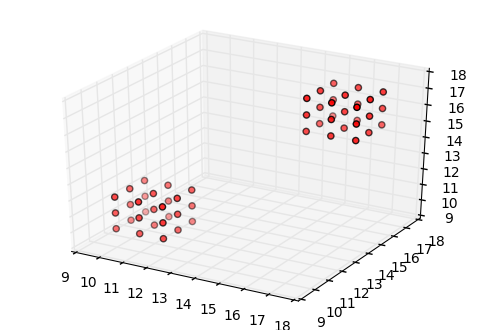

In [3]:
#The two cluster data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = twoClusterDat.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

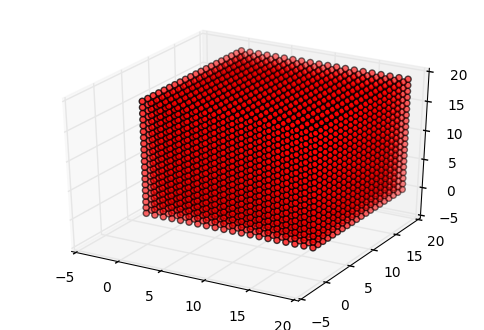

In [5]:
#The uniform data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = all100Dat.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

**2. Generate Functionality Results**

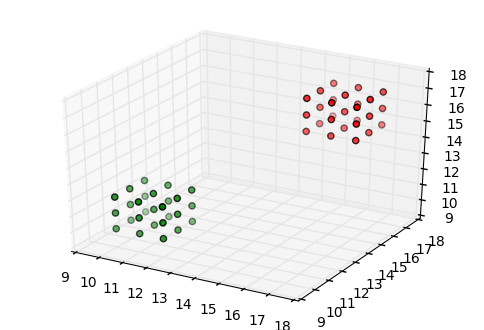

In [63]:
#thresholds the two-cluster data using Otsu's Binarization
thresh = cLib.otsuVox(twoClusterDat)
connect = connectedComponents(thresh)

#the image for the first cluster
displayCluster1 = np.zeros_like(twoClusterDat)
for i in range(len(connect[2].members)):
    displayCluster1[connect[2].members[i][0]][connect[2].members[i][1]][connect[2].members[i][2]] = 1
    
#the image for the second cluster    
displayCluster2 = np.zeros_like(twoClusterDat)
for i in range(len(connect[1].members)):
    displayCluster2[connect[1].members[i][0]][connect[1].members[i][1]][connect[1].members[i][2]] = 2

#displayin these images in different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z1, y1, x1 = displayCluster1.nonzero()
z2, y2, x2 = displayCluster2.nonzero()
ax.scatter(x1, y1, z1, zdir='z', c='r')
ax.scatter(x2, y2, z2, zdir='z', c='g')
plt.show()

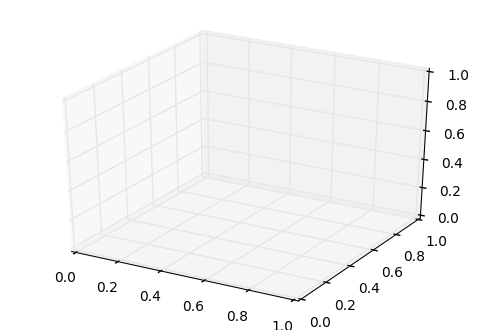

In [62]:
#thresholds the two-cluster data using Otsu's Binarization
thresh = cLib.otsuVox(all100Dat)
connect = connectedComponents(thresh)

#the image of the connected components
displayCluster = np.zeros_like(twoClusterDat)
for cluster in range(len(connect)):
    for i in range(len(connect[cluster].members)):
        displayCluster1[connect[cluster].members[i][0]][connect[cluster].members[i][1]][connect[cluster].members[i][2]] = 1
    
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = displayCluster.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

**3. Analyze Functionality Results**
The results are consistent with the hypothesis. The data performed well on an image that contains distinct, disparate clusters, and poorly on an image that is uniform and does not contain any clusters. 

## 3. Validation Testing
**1. Displaying raw data**

Validation testing will be performed on a a 100x100x100 volume with a pixel intensity distribution approximately the same as that of the true image volumes (i.e., 98% noise, 2% synapse). The synapse pixels will be grouped together in clusters as they would in the true data. Based on research into the true size of synapses, these synthetic synapse clusters will be given area of ~.2 microns ^3, or about 27 voxels (assuming the synthetic data here and the real world data have identical resolutions). After the data goes through the pipeLine, I will gauge performance based on the following:

1. volumetric percentage of data (should be 2% of the data)
2. average volume of synapses (should be 27 voxels) 
3. background percentage of data (should be 0%)

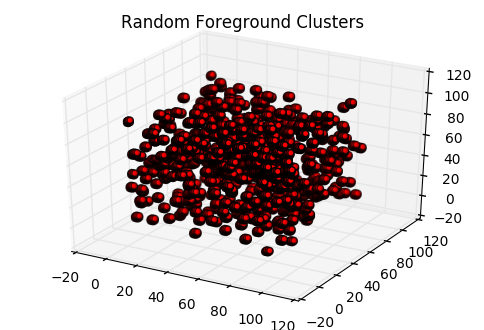

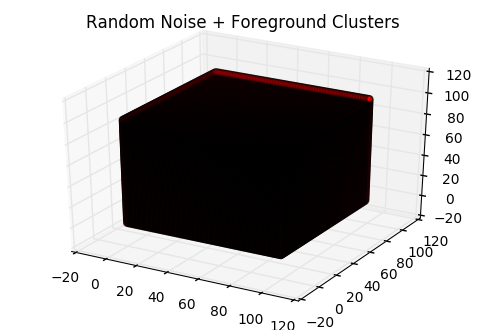

In [2]:
from random import randrange as rand
from skimage.measure import label

def generatePointSet():
    center = (rand(0, 99), rand(0, 99), rand(0, 99))
    toPopulate = []
    for z in range(-1, 2):
        for y in range(-1, 2):
            for x in range(-1, 2):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 100:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = set()
    for _ in range(rand(500, 800)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = rand(0, 10000)
    return volume, noiseVolume

randIm = generateTestVolume()
foreground = randIm[0]
combinedIm = randIm[1]

#displaying the random clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = foreground.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Foreground Clusters')
plt.show()

#displaying the noise
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = combinedIm.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Noise + Foreground Clusters')
plt.show()

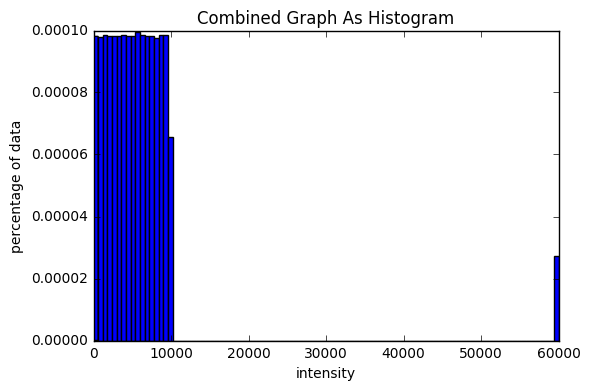

In [3]:
mouseVis.generateHist(combinedIm, bins = 100, title = 'Combined Graph As Histogram', xaxis = "intensity", yaxis = "percentage of data")

**2. Predicting Performance**
Looking at the data, there seem to be many large distinct clusters, as well as a good amount of background noise. It is also clearly bimodal. This leads me to believe that the the connectLib pipeline will filter out the background noise and effectively group the foreground clusters. To evaluate performance, I will check two statistics: 

1. The average volume of the clusters
2. The density of clusters by volume

**3. Generate Performance** 

In [ ]:
#finding the clusters after plosPipeline - realistically lists the centers of the clusters
plosOut = pLib.pipeline(combinedIm)
bianOut = cLib.otsuVox(plosOut)
connectList = cLib.connectedComponents(bianOut)

In [ ]:
#putting the plosPipeline clusters volumes in a list
plosClusterVolList =[]
for cluster in (range(len(connectList))):
    plosClusterVolList.append(connectList[cluster].getVolume())

In [ ]:
#finding the upper outlier fence
upperThreshFence = 1.5*np.percentile(plosClusterVolList, 75)

#filtering out the background cluster
upperThreshClusterList = []
for cluster in (range(len(connectList))):
    if connectList[cluster].getVolume() < upperThreshFence:
        upperThreshClusterList.append(connectList[cluster])

In [ ]:
#creating a list of all the member indices of the plos connectList
plosClusterMemberList = []
for cluster in range(len(upperThreshClusterList)):
    plosClusterMemberList.extend(upperThreshClusterList[cluster].members)

In [ ]:
#finding the clusters without plosPipeline - lists the entire clusters
bianRawOut = cLib.otsuVox(combinedIm)
connectRawList = cLib.connectedComponents(bianRawOut)

In [ ]:
#creating a list of all the clusters without any decay
completeClusterMemberList =[]
for rawCluster in range(len(connectRawList)):
    for index in range(len(plosClusterMemberList)):
        if plosClusterMemberList[index] in connectRawList[rawCluster].members:
            completeClusterMemberList.append(connectRawList[rawCluster])

In [ ]:
#finding the total volume of our co-registered list 
totalCoVol = 0
for cluster in range(len(completeClusterMemberList)):
    totalCoVol += completeClusterMemberList[cluster].getVolume()
avgCoVol = totalCoVol*1.0/len(completeClusterMemberList)

#finding the actual volume 
foregroundClusterList = cLib.connectedComponents(foreground)
del foregroundClusterList[0]
totalActualVol = 0
for cluster in range(len(foregroundClusterList)):
    totalActualVol += foregroundClusterList[cluster].getVolume()
avgActualVol = totalActualVol*1.0/len(foregroundClusterList)

print 'Test1: Avg Volume'
print "\tExpected: " + str(avgActualVol) + '\tActual: ' + str(avgCoVol)

print 'Test2: Cluster Density of Data By Volume'
print "\tExpected: " + str(totalActualVol/(100*100*100.0)) + '\tActual: ' + str(totalCoVol/(100*100*100.0))

**3. Document performance accuracy relative to predictions**
As predicted, the larger clusters were semgented very well, while the smaller, grouped clusters were segmented into groups rather than individually. The background was also segmented into a grid. In the future, an algorithm that allows segmentation with non-restrictive segmentation size would improve performance, as it could group the entire background into one segment, and segment each small cluster individually rather than group them together as to equalize the size of the segments. An algorithm that has a 3-dimensional implimentation would also be more 